In [45]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.noise import GaussianNoise
from keras.utils import np_utils
from keras.constraints import maxnorm

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras import backend as K
K.set_image_data_format('channels_first')

import seaborn as sns

In [4]:
HSC_ids = np.load("HSC_ids.npy")
HSC_ids

array([43158176442374224, 43158176442374373, 43158176442374445, ...,
       43159155694916013, 43159155694916476, 43159155694917496])

In [5]:
X = np.load("images.small.npy")
X.shape

(1866, 3, 50, 50)

# Get targets

In [8]:
df = pd.read_csv("data/2018_02_23-all_objects.csv")
df = df[df.selected]
df.head()



targets = df.drop_duplicates("HSC_id") \
            .set_index("HSC_id") \
    


targets = (targets.log_mass > 8) & (targets.log_mass < 9) & (targets.photo_z < .15)
print(targets.mean())
print(targets.sum())

0.2775
555


# Split training and validation sets

In [14]:
randomized_indices = np.arange(X.shape[0])
np.random.shuffle(randomized_indices)

testing_fraction = 0.2
testing_set_indices = randomized_indices[:int(testing_fraction*X.shape[0])]
training_set_indices = np.array(list(set([*randomized_indices]) - set([*testing_set_indices])))

In [16]:
testing_set_indices.size


373

In [15]:
training_set_indices.size


1493

# Setup standard augmentation

In [9]:
# from keras.preprocessing.image import NumpyArrayIterator

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
print('Using real-time _simple_ data augmentation.')

h_before, w_before = X[0,0].shape
print("image shape before: ({},{})".format(h_before, w_before))

# this will do preprocessing and realtime data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    horizontal_flip=True, # randomly apply a reflection (in x)
    vertical_flip=True, # randomly apply a reflection (in y)
    rotation_range=0, # randomly apply a rotation of angle randomly between 0 and `rotation_range`
    zoom_range=0.0,
    shear_range=0.0,
    channel_shift_range=0.0,
    rescale=0,
    width_shift_range=0.002,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.002,  # randomly shift images vertically (fraction of total height)
)

Using real-time _simple_ data augmentation.
image shape before: (50,50)


In [17]:
datagen.fit(X[training_set_indices])

# Setup `keras` model

In [20]:
n_conv_filters = 16
conv_kernel_size = 4
input_shape = X.shape[1:]

dropout_fraction = .25

nb_dense = 64

In [52]:
input_shape

(3, 50, 50)

In [21]:
model = Sequential()

model.add(Conv2D(n_conv_filters, conv_kernel_size,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))


model.add(Conv2D(n_conv_filters, conv_kernel_size*2,
                        padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Conv2D(n_conv_filters, conv_kernel_size*4,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Flatten())
model.add(Dense(2*nb_dense, activation="relu"))
model.add(Dense(nb_dense, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [25]:
learning_rate = 0.001
decay = 1e-5
momentum = 0.9

sgd = SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)

adam = Adam(lr=learning_rate)

In [26]:
model.compile(loss='binary_crossentropy', 
#               optimizer=sgd, 
              optimizer=adam,
#               metrics=["accuracy"]
             )

In [27]:
earlystopping = EarlyStopping(monitor='loss',
                              patience=35,
                              verbose=1,
                              mode='auto' )


# Run Basic Keras Model

In [28]:
goal_batch_size = 64
steps_per_epoch = max(2, training_set_indices.size//goal_batch_size)
batch_size = training_set_indices.size//steps_per_epoch
print("steps_per_epoch: ", steps_per_epoch)
print("batch_size: ", batch_size)
epochs = 100
verbose=1

steps_per_epoch:  23
batch_size:  64


In [32]:
Y = targets[HSC_ids].values

In [33]:
# %%timeit -r 1 -n 1
history = model.fit_generator(datagen.flow(X[training_set_indices], Y[training_set_indices],
                                           batch_size=batch_size,
                                          ),
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=(X[testing_set_indices], Y[testing_set_indices]),
                              verbose=verbose,
                              callbacks=[earlystopping],
                              )  

Epoch 1/100
23/23 [==============================] - 16s 710ms/step - loss: 0.6216 - val_loss: 0.6263
Epoch 2/100
23/23 [==============================] - 15s 670ms/step - loss: 0.6238 - val_loss: 0.6381
Epoch 3/100
23/23 [==============================] - 15s 647ms/step - loss: 0.6032 - val_loss: 0.5747
Epoch 4/100
23/23 [==============================] - 14s 604ms/step - loss: 0.6037 - val_loss: 0.5970
Epoch 5/100
23/23 [==============================] - 14s 591ms/step - loss: 0.5867 - val_loss: 0.5747
Epoch 6/100
23/23 [==============================] - 14s 612ms/step - loss: 0.5927 - val_loss: 0.5699
Epoch 7/100
23/23 [==============================] - 13s 577ms/step - loss: 0.5781 - val_loss: 0.5880
Epoch 8/100
23/23 [==============================] - 14s 592ms/step - loss: 0.5901 - val_loss: 0.5670
Epoch 9/100
23/23 [==============================] - 14s 605ms/step - loss: 0.5812 - val_loss: 0.5603
Epoch 10/100
23/23 [==============================] - 14s 590ms/step - loss: 0.572

23/23 [==============================] - 14s 619ms/step - loss: 0.4977 - val_loss: 0.5618
Epoch 81/100
23/23 [==============================] - 14s 593ms/step - loss: 0.4581 - val_loss: 0.5655
Epoch 82/100
23/23 [==============================] - 14s 594ms/step - loss: 0.4726 - val_loss: 0.5917
Epoch 83/100
23/23 [==============================] - 13s 576ms/step - loss: 0.5060 - val_loss: 0.5807
Epoch 84/100
23/23 [==============================] - 14s 602ms/step - loss: 0.4789 - val_loss: 0.5686
Epoch 85/100
23/23 [==============================] - 14s 613ms/step - loss: 0.4719 - val_loss: 0.5667
Epoch 86/100
23/23 [==============================] - 14s 593ms/step - loss: 0.4685 - val_loss: 0.5745
Epoch 87/100
23/23 [==============================] - 17s 724ms/step - loss: 0.4650 - val_loss: 0.5761
Epoch 88/100
23/23 [==============================] - 16s 706ms/step - loss: 0.4885 - val_loss: 0.5662
Epoch 89/100
23/23 [==============================] - 17s 740ms/step - loss: 0.4580 - 

In [51]:
print("best performance: ", min(history.history["val_loss"]))

best performance:  0.5326825762242479


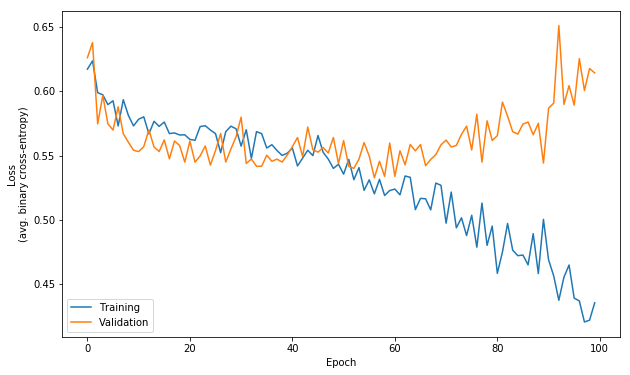

In [36]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):

    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")

    plt.legend()
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss\n(avg. binary cross-entropy)")

In [44]:
class_probs = model.predict_proba(X[testing_set_indices]).flatten()
class_probs

373/373 [==============================] - 1s 4ms/step


array([1.98324963e-01, 7.03137591e-02, 1.57926261e-01, 2.79973567e-01,
       4.75521594e-01, 1.74859405e-01, 5.89594170e-02, 5.12222707e-01,
       3.73675406e-01, 2.24280611e-01, 2.93932766e-01, 3.63723218e-01,
       8.60050321e-02, 4.82280292e-02, 2.85049225e-03, 8.54874328e-02,
       1.50511220e-01, 3.86579216e-01, 3.60130258e-02, 1.42304331e-01,
       8.96415040e-02, 1.57194231e-02, 6.83652163e-02, 2.46866997e-02,
       2.60563463e-01, 7.83176124e-02, 1.44004682e-02, 1.19714916e-01,
       7.03972697e-01, 2.34222665e-01, 3.32428396e-01, 4.67984915e-01,
       2.39267070e-02, 6.19292676e-01, 7.08940253e-02, 1.32923927e-02,
       2.16960490e-01, 5.92757165e-01, 2.44019665e-02, 3.90118994e-02,
       2.67968029e-01, 8.07180908e-03, 4.35525447e-01, 5.02963066e-01,
       3.53498131e-01, 2.10962281e-01, 5.79234123e-01, 4.70969528e-01,
       1.12319060e-01, 3.51429701e-01, 1.92165762e-01, 2.85571486e-01,
       7.66219795e-01, 1.99955225e-01, 4.84529555e-01, 2.19149560e-01,
      

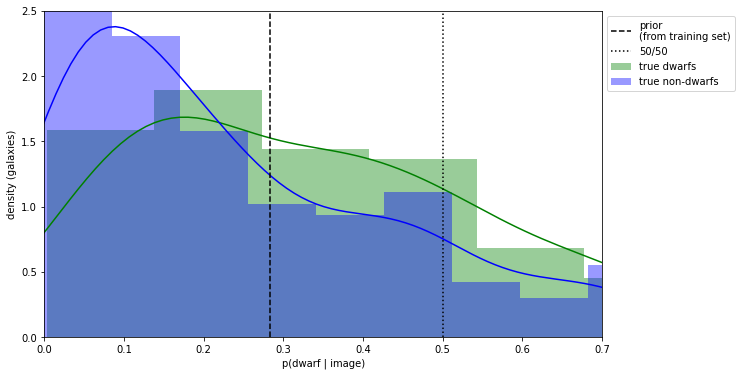

In [46]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    sns.distplot(class_probs[Y[testing_set_indices]==True], color="g", label="true dwarfs")
    sns.distplot(class_probs[Y[testing_set_indices]==False], color="b", label="true non-dwarfs")

    plt.xlabel("p(dwarf | image)")
    plt.ylabel("density (galaxies)")

    plt.xlim(0, .7)
    plt.axvline(Y[training_set_indices].mean(), linestyle="dashed", color="black", label="prior\n(from training set)")
    plt.axvline(.5, linestyle="dotted", color="black", label="50/50")

    plt.legend(
        loc="upper left",
        bbox_to_anchor=(1, 1),
    )


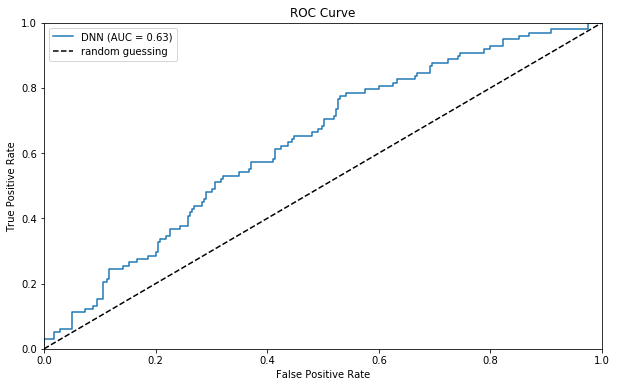

In [47]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    fpr, tpr, _ = metrics.roc_curve(Y[testing_set_indices], class_probs)
    roc_auc = roc_auc_score(Y[testing_set_indices], class_probs)

    plt.plot(fpr, tpr, label="DNN (AUC = {:.2})".format(roc_auc))
    plt.plot([0,1], [0,1], linestyle="dashed", color="black", label="random guessing")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title("ROC Curve")

    plt.legend(loc="best")


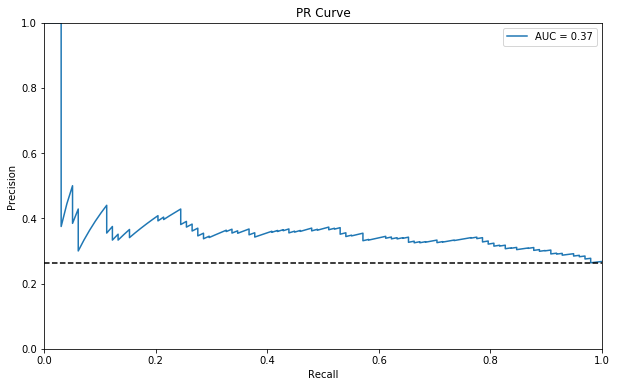

In [48]:
from sklearn import metrics
from sklearn.metrics import average_precision_score
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    precision, recall, _ = metrics.precision_recall_curve(Y[testing_set_indices], class_probs)
    pr_auc = average_precision_score(Y[testing_set_indices], class_probs)

    plt.plot(recall, precision, label="AUC = {:.2}".format(pr_auc))
    plt.plot([0,1], [Y[testing_set_indices].mean()]*2, linestyle="dashed", color="black")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.title("PR Curve")

    plt.legend(loc="best")


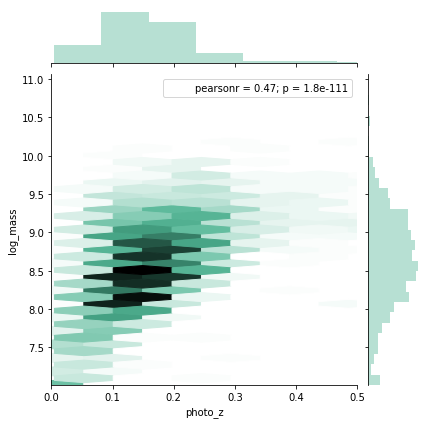

In [63]:
df_tmp = df.drop_duplicates("HSC_id") \
           .set_index("HSC_id") \
          [["photo_z", "log_mass"]]

sns.jointplot(df_tmp.photo_z, 
              df_tmp.log_mass, kind="hex", 
#               stat_func=kendalltau, 
              color="#4CB391",
              xlim=(0,.5),
             )

sns.jointplot?

In [ ]:
sns.